In [1]:
import pycns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
from params import *
from configuration import *
from icp_jobs import *
from tools import *

# ICP CHAN NAMES

In [2]:
for sub in subs:
    cns_reader = pycns.CnsReader(data_path / sub)
    stream_names = list(cns_reader.streams.keys())
    stream_with_P = [name for name in stream_names if ('P' in name and len(name) < 4)]
    stream_with_P = [n for n in stream_with_P if not n in ['CPP','ABP']]
    print(sub, stream_with_P)

Patient_2024_May_16__9_33_08_427295 ['P1', 'P2']
Patient_2024_May_13__9_36_06_745131 ['P1']
Patient_2024_May_8__9_51_19_328502 ['ICP', 'P1']
Patient_2024_May_25__16_09_03_881877 ['ICP', 'P1']
Patient_2024_Sep_10__11_32_35_613533 ['ICP', 'P']
Patient_2024_May_25__16_48_44_716049 ['P1', 'P']
Patient_2024_Jun_24__12_33_38_160174 ['ICP', 'P1', 'P']
PatientData_1723890119868125 ['ICP', 'P1', 'P']


# PARAMS

In [3]:
win_size_hours = 1

# PSI PLOT

In [ ]:
for sub in subs:
    has_dvi = get_metadata(sub)['DVI']
    start_dates = get_date_windows_gmt(sub)
    da_psi = psi_job.get(sub)['psi']
    compute_stream = get_piv_chan_name(sub)
    fig, ax = plt.subplots()
    ax.set_ylabel('PSI')
    ax.set_xlabel('Date')
    ax.set_ylim(-0.2, 4.2)
    ax.plot(da_psi['date'], da_psi.values, color='k', lw = 2)
    ax.set_title(f'{sub} (DVI = {has_dvi})\ncompute stream = {compute_stream}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    for win_label, c in zip(start_dates.keys(),['r','g']):
        start_span = start_dates[win_label]
        stop_span = start_span + np.timedelta64(win_size_hours, 'h')
        ax.axvspan(start_span, stop_span, color = c, alpha = 0.2, label = win_label)
    ax.legend()
    fig.savefig(base_folder / 'results' / 'psi' / f'{sub}.png', dpi = 200, bbox_inches = 'tight')
    plt.show()

# SIGNAL SAMPLE PLOT

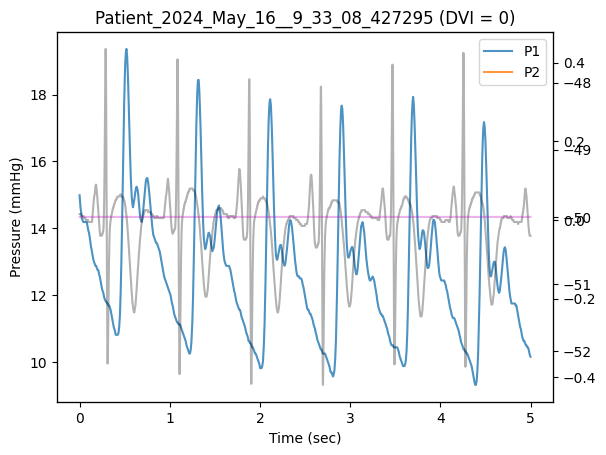

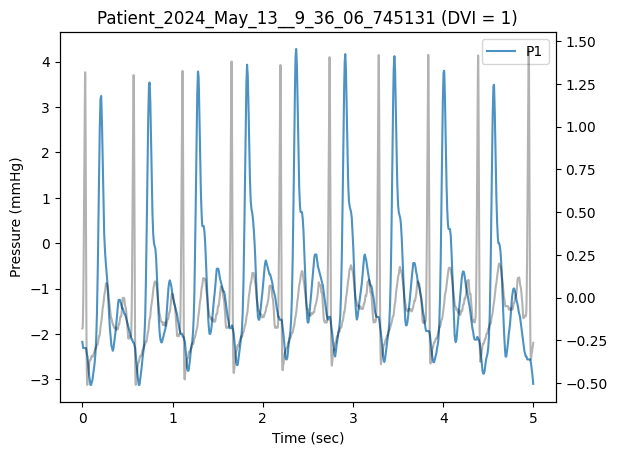

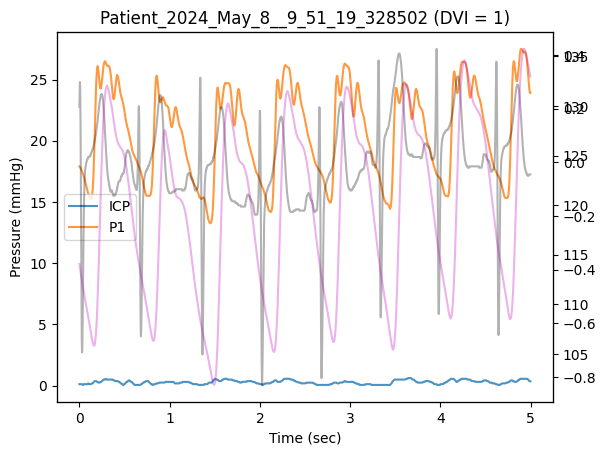

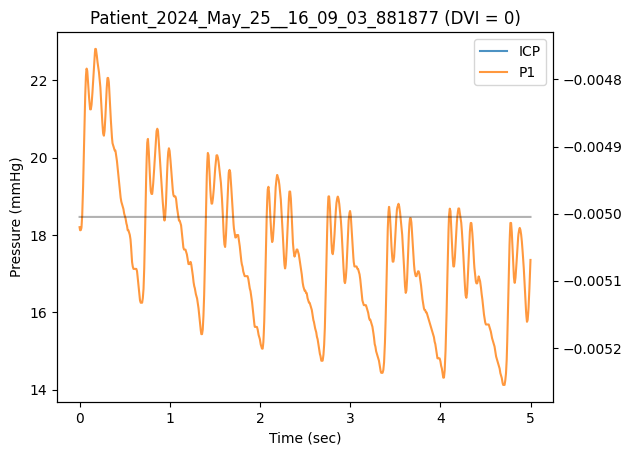

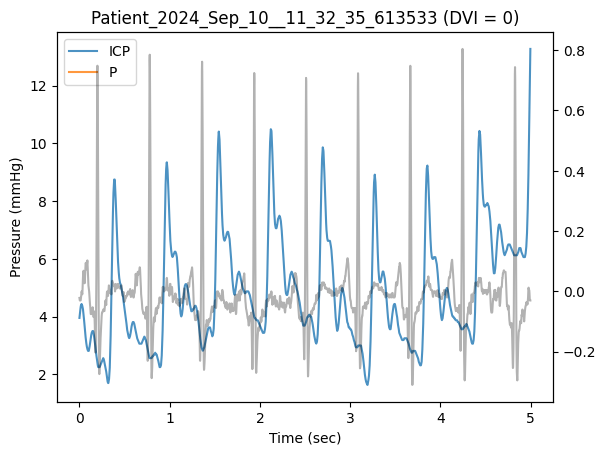

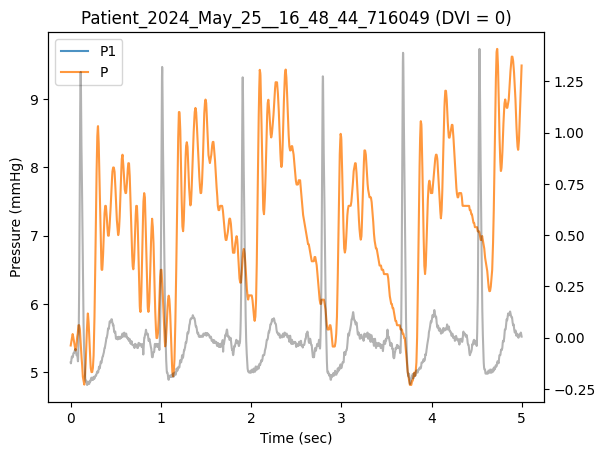

In [29]:
# sec_start = 3600
duration_secs = 5

srate = 512

# for sec_start in [1000, 2000, 3600]:
for sec_start in [3600, 7200]:
    sec_stop =  sec_start + duration_secs
    for sub in subs:
        has_dvi = get_metadata(sub)['DVI']
        cns_reader = pycns.CnsReader(data_path / sub)
        stream_names = list(cns_reader.streams.keys())
        stream_with_P = [name for name in stream_names if ('P' in name and len(name) < 4)]
        stream_with_P = [n for n in stream_with_P if not n in ['CPP','ABP']]
        add_streams = ['ECG_II','ABP'] if 'ABP' in stream_names else ['ECG_II']
        load_streams = stream_with_P + add_streams
        da = cns_reader.export_to_xarray(load_streams, resample=True, sample_rate=srate).to_array()
        da = da[:,int(sec_start * srate):int(srate * sec_stop)]
        t = np.arange(da.shape[1]) / srate
        fig, ax = plt.subplots()
        ax.set_title(f'{sub} (DVI = {has_dvi})')
        for stream_name in stream_with_P:
            plot_sig = da.loc[stream_name,:].values
            ax.plot(t, plot_sig, label = stream_name, alpha = 0.8)
        
        ax2 = ax.twinx()
        ax2.plot(t, da.loc['ECG_II',:].values, color = 'k', alpha = 0.3)
        if 'ABP' in add_streams:
            ax3 = ax.twinx()
            ax3.plot(t, da.loc['ABP',:].values, color = 'm', alpha = 0.3)

        ax.set_ylabel('Pressure (mmHg)')
        ax.set_xlabel('Time (sec)')
        ax.legend() 
        fig.savefig(base_folder / 'results' / 'sample_signal' / f'{sub}_sec_start{sec_start}.png', dpi = 200, bbox_inches = 'tight')
        plt.show()

# ALL ICP PLOT

In [ ]:
for sub in subs:
    start_dates = get_date_windows_gmt(sub)
    has_dvi = get_metadata(sub)['DVI']
    cns_reader = pycns.CnsReader(data_path / sub)
    stream_name = get_piv_chan_name(sub)
    stream_name = f'{stream_name}_Mean'
    fig, ax = plt.subplots()
    ax.set_title(f'{sub} (DVI = {has_dvi})')
    stream = cns_reader.streams[stream_name]
    srate = stream.sample_rate
    raw_icp, dates = stream.get_data(apply_gain=True, with_times = True)
    ax.plot(dates, raw_icp, label = stream_name, alpha = 0.8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_ylabel('Pressure (mmHg)')
    ax.set_xlabel('Time (sec)')
    for win_label, c in zip(start_dates.keys(),['r','g']):
        start_span = start_dates[win_label]
        stop_span = start_span + np.timedelta64(win_size_hours, 'h')
        ax.axvspan(start_span, stop_span, color = c, alpha = 0.2, label = win_label)
    ax.legend()
    fig.savefig(base_folder / 'results' / 'whole_pressure' / f'{sub}.png', dpi = 200, bbox_inches = 'tight')
    plt.show()

# PULSE WAVEFORM 

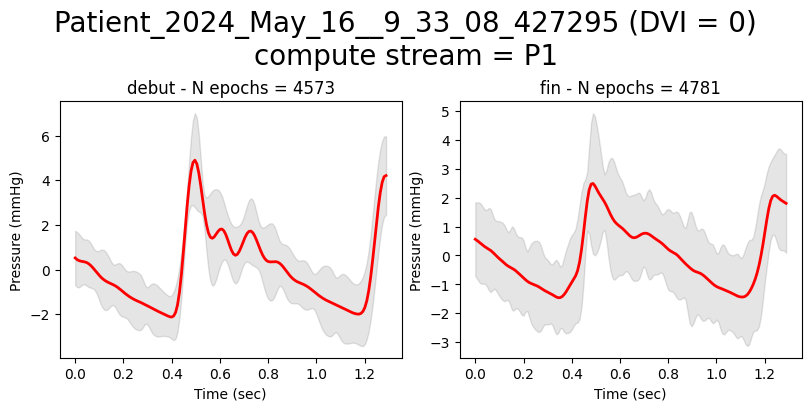

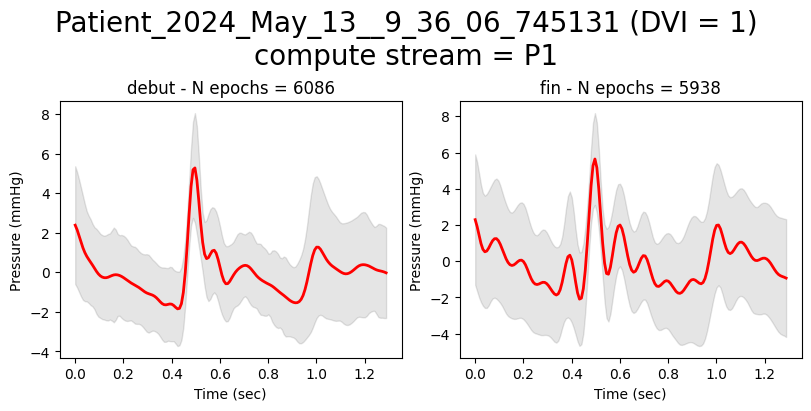

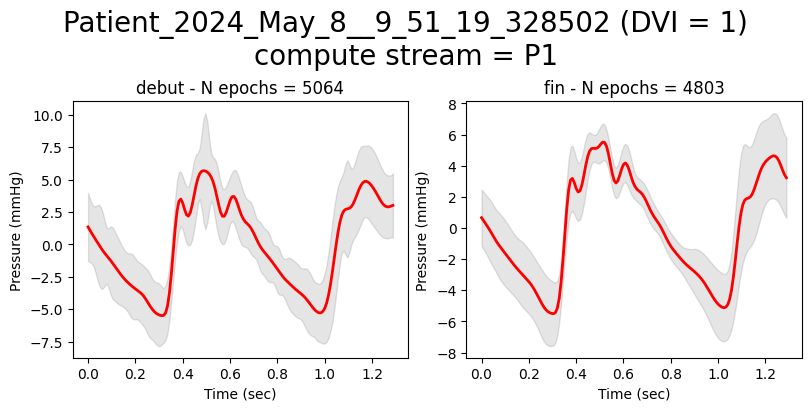

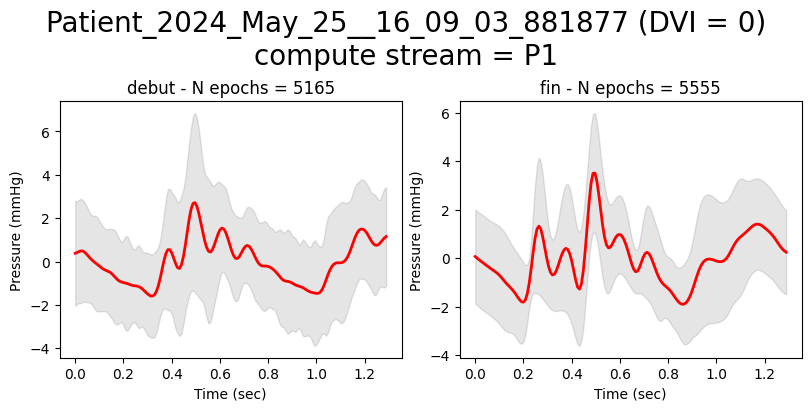

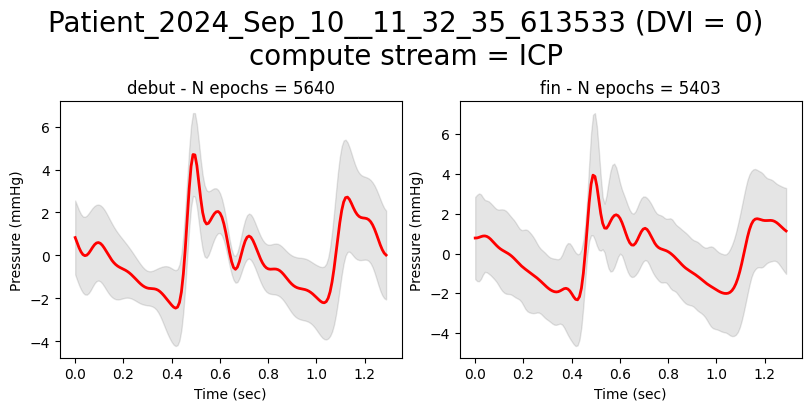

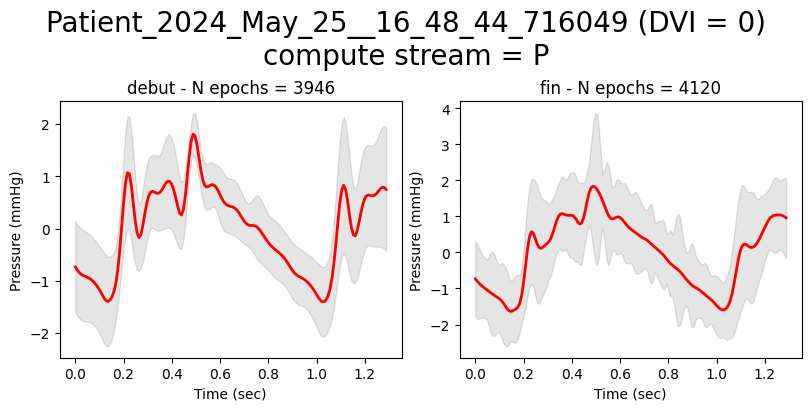

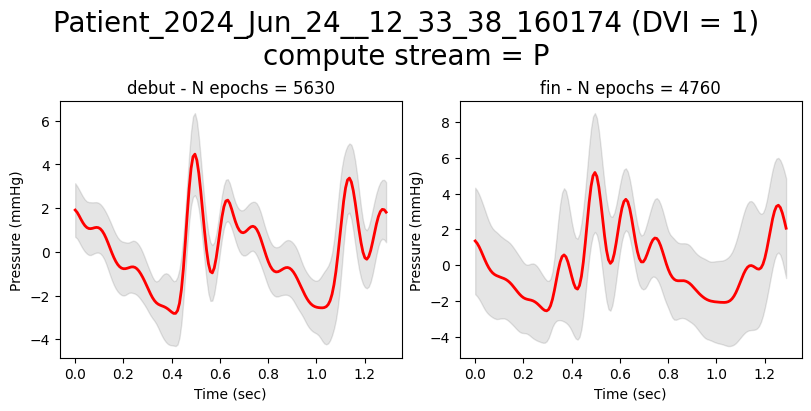

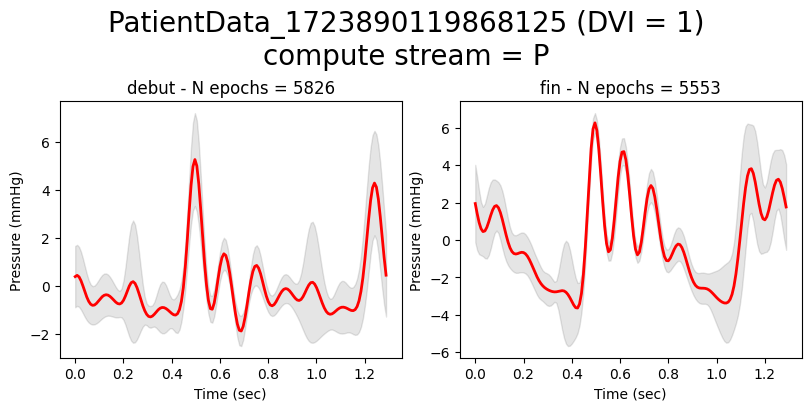

In [28]:
ms_before_peak = 500
ms_after_peak = 800

win_duration_ms = ms_before_peak + ms_after_peak

for sub in subs:
    has_dvi = get_metadata(sub)['DVI']
    stream_name = get_piv_chan_name(sub)
    start_dates = get_date_windows_gmt(sub)
    cns_reader = pycns.CnsReader(data_path / sub)
    stream = cns_reader.streams[stream_name]
    srate = stream.sample_rate
    raw_icp , dates = stream.get_data(with_times = True, apply_gain = True)
    icp_detections = detect_icp_job.get(sub).to_dataframe()

    ncols = len(start_dates)
    fig, axs = plt.subplots(ncols = ncols, figsize = (ncols * 4,4), constrained_layout = True)
    fig.suptitle(f"{sub} (DVI = {has_dvi})\ncompute stream = {stream_name}", fontsize = 20)
    for c, win_label in enumerate(start_dates.keys()):
        start_date = start_dates[win_label]
        stop_date = start_date + np.timedelta64(win_size_hours, 'h')
        
        icp_detections_mask = (icp_detections['peak_date'] > start_date) & (icp_detections['peak_date'] < stop_date)
        local_icp_detections = icp_detections[icp_detections_mask].reset_index(drop = True)
        
        n_epochs = local_icp_detections.shape[0]
        epochs = None

        for i, row in local_icp_detections.iterrows():
            peak_ind = row['peak_ind']
            win_start_ind = peak_ind - int(ms_before_peak / 1000 * srate)
            win_stop_ind = win_start_ind + int(win_duration_ms / 1000 * srate)
            epoch = raw_icp[win_start_ind:win_stop_ind]

            if epochs is None:
                epochs = np.zeros((n_epochs, epoch.size))
            epochs[i,:] = epoch

        epochs = epochs - np.mean(epochs, axis = 1)[:,None]
        m = np.mean(epochs, axis = 0)
        s = np.std(epochs, axis = 0)
        t = np.arange(m.size) / srate

        ax = axs[c]
        ax.plot(t, m, color = 'r', lw = 2)
        ax.fill_between(t, m-s, m+s, color = 'k', alpha = 0.1)
        ax.set_ylabel('Pressure (mmHg)')
        ax.set_xlabel('Time (sec)')
        ax.set_title(f'{win_label} - N epochs = {n_epochs}')

    fig.savefig(base_folder / 'results' / 'pulse_waveform' / f'{sub}.png', dpi = 200, bbox_inches = 'tight')
    plt.show()  

# STATS

/home/valentin.ghibaudo/.virtualenvs/py3.11_cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/valentin.ghibaudo/.virtualenvs/py3.11_cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/valentin.ghibaudo/.virtualenvs/py3.11_cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/valentin.ghibaudo/.virtualenvs/py3.11_cluster/lib/python3.11/site-packages/seaborn

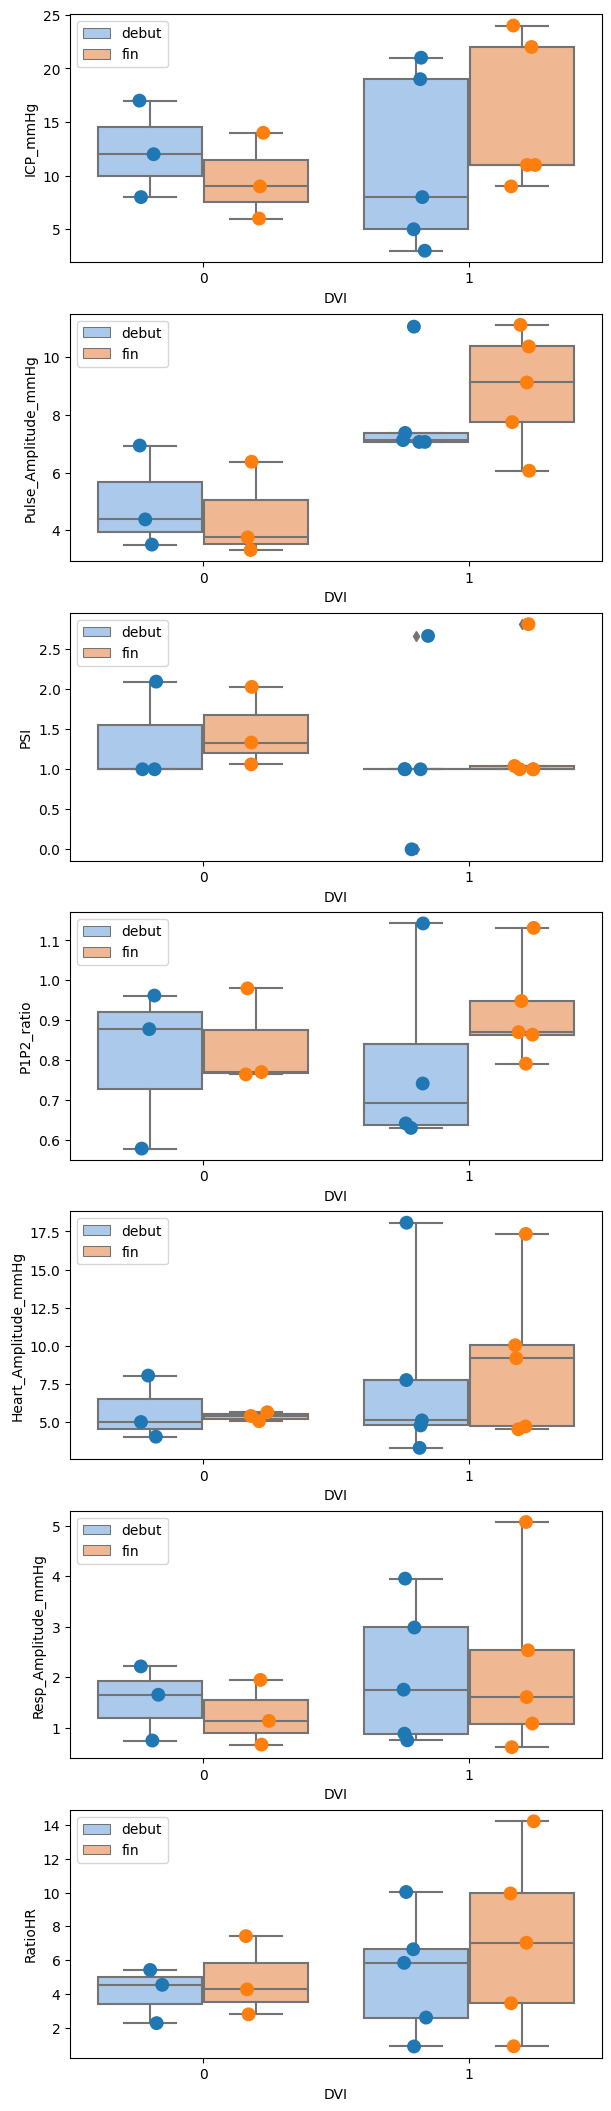

In [2]:
metrics = concat_metrics_job.get('global_key').to_dataframe()
predictors = ['DVI','Période']
outcomes = ['ICP_mmHg','Pulse_Amplitude_mmHg','PSI','P1P2_ratio','Heart_Amplitude_mmHg','Resp_Amplitude_mmHg','RatioHR']
outcomes = outcomes

concat_aov = []

nrows = len(outcomes)
fig, axs = plt.subplots(nrows=nrows, figsize = (6, nrows * 3), constrained_layout = True)
for r, outcome in enumerate(outcomes):
    ax = axs[r]
    keep_cols = ['Patient'] + predictors + [outcome]
    metrics_stats = metrics[keep_cols].dropna()

    aov = pg.mixed_anova(dv=outcome, between='DVI',within='Période', subject='Patient', data=metrics_stats)
    aov['outcome'] = outcome
    
    concat_aov.append(aov)
    
    sns.boxplot(data = metrics_stats,
                    x = 'DVI',
                    y = outcome,
                    hue = 'Période',
                    ax=ax,
                    palette = sns.color_palette("pastel"),
                    whis=5
                    # bw=0.3
                    )
    sns.stripplot(data = metrics_stats,
                    x = 'DVI',
                    y = outcome,
                    hue = 'Période',
                    ax=ax,
                    dodge = True,
                    size = 10,
                    legend = False
                    )
    # sns.lineplot(data = metrics_stats,
    #                 x = 'Période',
    #                 y = outcome,
    #                 hue = 'DVI',
    #                 units = 'Patient',
    #                 ax=ax,
    #                 legend = False,
    #                 estimator = None,
    #                 lw = 0.5
    #                 )
    ax.legend(loc = 'upper left', fontsize = 10, ncols = 1)
fig.savefig(base_folder / 'results' / 'figs_interaction.png' , dpi = 500, bbox_inches = 'tight')
plt.show(fig)


res = pd.concat(concat_aov)
res['p-corr'] = pg.multicomp(res['p-unc'], method = 'holm')[1]
res['signif-unc'] = res['p-unc'].apply(lambda x:0 if x > 0.05 else 1)
res['signif-corr'] = res['p-corr'].apply(lambda x:0 if x > 0.05 else 1)
res.to_excel(base_folder / 'results' / 'mixed_anovas.xlsx')

In [4]:
res

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps,outcome,p-corr,signif-unc,signif-corr
0,DVI,19.837503,1,6,19.837503,0.227321,0.650386,0.036504,NaN,ICP_mmHg,1.000000,0,0
1,Période,10.562500,1,6,10.562500,3.211564,0.123297,0.348645,1.0,ICP_mmHg,1.000000,0,0
2,Interaction,44.204123,1,6,44.204123,13.440413,0.010503,0.691365,NaN,ICP_mmHg,0.220556,1,0
0,DVI,51.453190,1,6,51.453190,10.671745,0.017103,0.640110,NaN,Pulse_Amplitude_mmHg,0.342067,1,0
1,Période,0.711914,1,6,0.711914,0.363080,0.568859,0.057060,1.0,Pulse_Amplitude_mmHg,1.000000,0,0
2,Interaction,1.859440,1,6,1.859440,0.948324,0.367755,0.136482,NaN,Pulse_Amplitude_mmHg,1.000000,0,0
0,DVI,0.105507,1,6,0.105507,0.103530,0.758548,0.016962,NaN,PSI,1.000000,0,0
1,Période,0.143594,1,6,0.143594,0.584960,0.473373,0.088833,1.0,PSI,1.000000,0,0
2,Interaction,0.015189,1,6,0.015189,0.061877,0.811850,0.010207,NaN,PSI,1.000000,0,0
0,DVI,0.005293,1,5,0.005293,0.090789,0.775305,0.017834,NaN,P1P2_ratio,1.000000,0,0
